In [24]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt, pi, exp

#from pandas_datareader import data
from statsmodels.tsa import stattools
from statsmodels.tsa import arima_model
from statsmodels.graphics import gofplots
from statsmodels.regression import linear_model

from scipy import stats
import scipy.integrate
import scipy.special
# from arch.unitroot import PhillipsPerron
import yfinance as yf
from sklearn.linear_model import LinearRegression

import os
import matplotlib.pyplot as plt  # for plotting
from statsmodels.regression import linear_model

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import statistics
import scipy.stats as si
from scipy.stats import norm

Data Download

In [3]:
tickers = ["CSCO","BAC","GE"]
#downoad the prices and volumes for the previously read list of tickers
start_date = '2021-09-01'
end_date = '2022-06-10'
stock_data = yf.download(tickers, start=start_date, end=end_date)
print(stock_data)

[*********************100%***********************]  3 of 3 completed
            Adj Close                             Close             \
                  BAC       CSCO          GE        BAC       CSCO   
Date                                                                 
2021-08-31  40.901459  57.884148  105.141502  41.750000  59.020000   
2021-09-01  40.352840  57.903759  103.395966  41.189999  59.040001   
2021-09-02  40.392231  58.384327  105.989342  41.020000  59.529999   
2021-09-03  40.421768  58.276443  104.483185  41.049999  59.419998   
2021-09-07  40.687637  57.746841  103.026909  41.320000  58.880001   
...               ...        ...         ...        ...        ...   
2022-06-03  36.189999  45.250000   76.970001  36.189999  45.250000   
2022-06-06  36.150002  45.330002   77.000000  36.150002  45.330002   
2022-06-07  36.349998  45.570000   78.000000  36.349998  45.570000   
2022-06-08  35.889999  44.919998   77.160004  35.889999  44.919998   
2022-06-09  34.509998

In [4]:
# Dividend Rates
csco = yf.Ticker("csco")
a_csco = csco.info['dividendRate']
a_csco = a_csco/100
print(a_csco)

ge = yf.Ticker("ge")
a_ge = ge.info['dividendRate']
a_ge = a_ge/100
print(a_ge)

bac = yf.Ticker("bac")
a_bac = bac.info['dividendRate']
a_bac = a_bac/100
print(a_bac)


0.0152
0.0032
0.0084


In [9]:
# Working on statistics
price = stock_data['Adj Close'].values
days = price.shape[0]
ret = price[1:]/price[:-1] - 1
#print(ret)

price_tab = np.array([])
ret_tab = np.array([])
for i in range(len(price)):
    price_tab = np.append(price_tab, price[i])
for i in range(len(ret)):
    ret_tab = np.append(ret_tab, ret[i])

price_tab = price_tab.reshape(days,3)
ret_tab = ret_tab.reshape(days-1,3)

df_price = pd.DataFrame(price_tab)
df_price.columns =['CSCO', 'BAC','GE']
df_ret = pd.DataFrame(ret_tab)
df_ret.columns=['CSCO', 'BAC','GE']
# Print prices
print(df_price)
#Print returns
print(df_ret)

hist_std_csco = np.std(df_ret["CSCO"])*np.sqrt(253)
hist_std_bac = np.std(df_ret["BAC"])*np.sqrt(253)
hist_std_ge = np.std(df_ret["GE"])*np.sqrt(253)

# Historical volatility
print(hist_std_csco)
print(hist_std_bac)
print(hist_std_ge)

          CSCO        BAC          GE
0    40.901459  57.884148  105.141502
1    40.352840  57.903759  103.395966
2    40.392231  58.384327  105.989342
3    40.421768  58.276443  104.483185
4    40.687637  57.746841  103.026909
..         ...        ...         ...
191  36.189999  45.250000   76.970001
192  36.150002  45.330002   77.000000
193  36.349998  45.570000   78.000000
194  35.889999  44.919998   77.160004
195  34.509998  44.259998   74.779999

[196 rows x 3 columns]
         CSCO       BAC        GE
0   -0.013413  0.000339 -0.016602
1    0.000976  0.008299  0.025082
2    0.000731 -0.001848 -0.014210
3    0.006577 -0.009088 -0.013938
4   -0.013069 -0.003397 -0.006874
..        ...       ...       ...
190 -0.013897 -0.011793 -0.013205
191 -0.001105  0.001768  0.000390
192  0.005532  0.005294  0.012987
193 -0.012655 -0.014264 -0.010769
194 -0.038451 -0.014693 -0.030845

[195 rows x 3 columns]
0.3042062445538259
0.290198303456069
0.3325626921984801


In [33]:
# Getting Call/Put options: Market Prices
opt_csco = csco.option_chain(date='2022-06-17')
options_cisco = opt_csco
print(options_cisco)

opt_bac = bac.option_chain(date='2022-06-17')
options_bac = opt_bac

opt_ge = ge.option_chain(date='2022-06-17')
options_ge = opt_ge

Options(calls=         contractSymbol             lastTradeDate  strike  lastPrice    bid  \
0   CSCO220617C00025000 2022-06-07 15:21:31+00:00    25.0      20.40  18.40   
1   CSCO220617C00027500 2022-06-03 13:44:56+00:00    27.5      17.95  15.90   
2   CSCO220617C00030000 2022-06-07 14:46:49+00:00    30.0      15.50  13.40   
3   CSCO220617C00032500 2022-05-20 13:38:39+00:00    32.5      10.00  10.90   
4   CSCO220617C00033000 2022-06-02 13:48:17+00:00    33.0      12.15  10.40   
5   CSCO220617C00034000 2022-05-25 14:18:40+00:00    34.0       9.80   9.40   
6   CSCO220617C00035000 2022-06-06 14:19:43+00:00    35.0      11.07   8.35   
7   CSCO220617C00037000 2022-06-08 17:52:59+00:00    37.0       8.10   6.40   
8   CSCO220617C00037500 2022-05-20 17:56:00+00:00    37.5       5.20   5.90   
9   CSCO220617C00038000 2022-06-10 15:12:43+00:00    38.0       5.55   5.40   
10  CSCO220617C00038500 2022-06-03 14:11:27+00:00    38.5       6.95   4.90   
11  CSCO220617C00039000 2022-05-25 18:

In [58]:
# Get Market Call Prices - CSCO
strike_call_list_cisco = (options_cisco[0]['strike'])
market_price_call_cisco = (options_cisco[0]['lastPrice'])
market_implied_vol_call_cisco = (options_cisco[0]['impliedVolatility'])
df_market_call = pd.DataFrame({'strike':strike_call_list_cisco ,
                   'lastPrice':market_price_call_cisco ,
                   'impliedVolatility': market_implied_vol_call_cisco})
#print(df_market_call)

# Get Market Put Prices - CSCO
strike_put_list_cisco = (options_cisco[1]['strike'])
market_price_put_cisco = (options_cisco[1]['lastPrice'])
market_implied_vol_put_cisco = (options_cisco[1]['impliedVolatility'])
df_market_put_cisco = pd.DataFrame({'strike':strike_put_list_cisco ,
                   'lastPrice':market_price_put_cisco ,
                   'impliedVolatility': market_implied_vol_put_cisco})

# Get Market Call Prices - GE
strike_call_list_ge = (options_ge[0]['strike'])
market_price_call_ge = (options_ge[0]['lastPrice'])
market_implied_vol_call_ge = (options_ge[0]['impliedVolatility'])
df_market_call_ge = pd.DataFrame({'strike':strike_call_list_ge ,
                   'lastPrice':market_price_call_ge ,
                   'impliedVolatility': market_implied_vol_call_ge})
#print(df_market_call)

# Get Market Put Prices - GE
strike_put_list_ge = (options_ge[1]['strike'])
market_price_put_ge = (options_ge[1]['lastPrice'])
market_implied_vol_put_ge = (options_ge[1]['impliedVolatility'])
df_market_put_ge = pd.DataFrame({'strike':strike_put_list_ge ,
                   'lastPrice':market_price_put_ge ,
                   'impliedVolatility': market_implied_vol_put_ge})


#print(df_market_call_ge)

SABR Model

Comparison Market implied volatilities and SABR model

Parameters: Black-Scholes

In [27]:
S_0_CSCO = 43.42            # stock price: CSCO
S_0_GE = 71.83              # stock price: GE
r = 1.14/100                # interest rate

sigma_CSCO = hist_std_csco  # volatility CSCO
sigma_GE = hist_std_ge      # volatility GE

K_CSCO = 47.50              # specific strike CSCO
K_GE = 72.50                # specific strike GE

Black-Scholes-Merton: Options Prices

In [30]:
def black_scholes_merton_call_div(S, K, T, r, a, sigma):

    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #a: dividend yield
    #sigma: volatility of underlying asset

    d1 = (np.log(S/K) + (r-a+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = (np.log(S/K) + (r-a-0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    call = (S*np.exp(-a*T) * si.norm.cdf(d1, 0.0, 1.0) - K*np.exp(-r*T) * si.norm.cdf(d2, 0.0, 1.0))
    return call


def black_scholes_put_div(S, K, T, r, a, sigma):

    d1_bs = (np.log(S/K) + (r-a+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2_bs = (np.log(S/K) + (r-a-0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    put = (K*np.exp(-r*T) * si.norm.cdf(-d2_bs, 0.0, 1.0) - S*np.exp(-a*T) * si.norm.cdf(-d1_bs, 0.0, 1.0))
    return put

In [31]:
T_test = 5
# Black-Scholes CSCO results
call_bs_CSCO =  black_scholes_merton_call_div(S_0_CSCO, K_CSCO, T_test, r, a_csco, hist_std_csco)
put_bs_CSCO =  black_scholes_put_div(S_0_CSCO, K_CSCO, T_test, r, a_csco, hist_std_csco)
# Black-Scholes GE results
call_bs_GE =  black_scholes_merton_call_div(S_0_GE, K_GE, T_test, r, a_ge, hist_std_ge)
put_bs_GE =  black_scholes_put_div(S_0_GE, K_GE, T_test, r, a_ge, hist_std_ge)

Black-Scholes-Merton: Greeks


In [32]:
def d1(S,K,T,r,a,sigma):
    return(log(S/K)+(r-a+sigma**2/2.)*T)/(sigma*sqrt(T))

def d2(S,K,T,r,a,sigma):
    return d1(S,K,T,r,a,sigma)-sigma*sqrt(T)

############## CALL OPTION ##############

def call_delta(S,K,T,r,a,sigma):
    return exp(-a*T)*norm.cdf(d1(S,K,T,r,sigma))

def call_gamma(S,K,T,r,a,sigma):
    return exp(-a*T)*norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))

def call_vega(S,K,T,r,sigma):
    return 0.01*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))

############## PUT OPTION ##############

def put_delta(S,K,T,r,a,sigma):
    return -exp(-a*T)*norm.cdf(-d1(S,K,T,r,sigma))

def put_gamma(S,K,T,r,a,sigma):
    return exp(-a*T)*norm.pdf(d1(S,K,T,r,sigma))/(S*sigma*sqrt(T))

def put_vega(S,K,T,r,a,sigma):
    return 0.01*exp(-a*T)*(S*norm.pdf(d1(S,K,T,r,sigma))*sqrt(T))

Monte-Carlo Simulation


Text(0, 0.5, 'frequency')

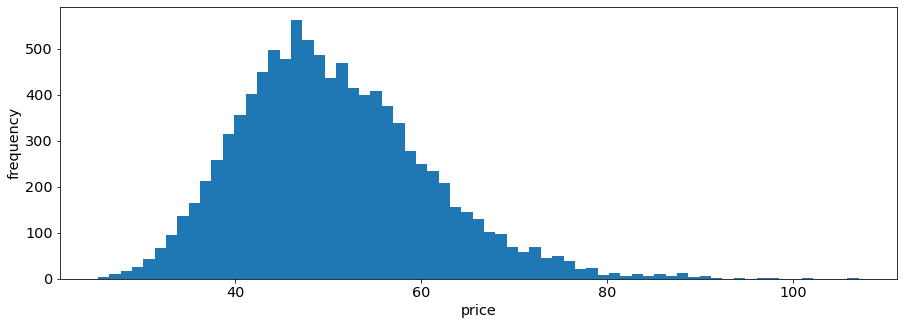

In [15]:
# Monte-Carlo Simulation:

# Parameters
T = 1.0
N = 10000
S_0 = 50
sigma = 0.20

# Example one-period simulation

# lognormal distribution of the price

Z = np.random.normal(size=N)
S_T = S_0*np.exp((r-0.5*sigma**2)*T+sigma*np.sqrt(T)*Z)
plt.hist(S_T, bins='auto')
plt.xlabel('price')
plt.ylabel('frequency')



In [20]:
# Monte Carlo simulation: European Option

call_payoff_maturity_CSCO = []
put_payoff_maturity_CSCO = []
call_payoff_maturity_GE = []
put_payoff_maturity_GE = []


days_test = 5 # 1 week = 5 trading days
dt = T/365

S_CSCO = np.zeros((days_test+1, N))
S_CSCO[0] = S_0_CSCO
S_GE = np.zeros((days_test+1, N))
S_GE[0] = S_0_GE

for t in range(1, days_test+1):
    Z_CSCO = np.random.normal(size=N)
    Z_GE = np.random.normal(size=N)
    S_CSCO[t] = S_CSCO[t-1]*np.exp((r-(a_csco/100)-0.5*sigma_CSCO**2)*dt+sigma_CSCO*np.sqrt(dt)*Z_CSCO)
    S_GE[t] = S_GE[t-1]*np.exp((r-(a_ge/100)-0.5*sigma_GE**2)*dt+sigma_GE*np.sqrt(dt)*Z_GE)

Valuation (European)

In [21]:
S_T_CSCO = S_CSCO[-1]
S_T_GE = S_GE[-1]
for i in range(len(S_T_CSCO)):
    call_payoff_maturity_CSCO.append(max(S_T_CSCO[i]-K_CSCO,0))
    put_payoff_maturity_CSCO.append(max(K_CSCO-S_T_CSCO[i],0))

    call_payoff_maturity_GE.append(max(S_T_GE[i]-K_GE,0))
    put_payoff_maturity_GE.append(max(K_GE-S_T_GE[i],0))

# Price of CSCO options: expiry on June 17, 2022
VMC_call_CSCO = np.mean(call_payoff_maturity_CSCO)
C_0_CSCO = VMC_call_CSCO*np.exp(-r*days_test/360)
print(C_0_CSCO)

VMC_put_CSCO = np.mean(put_payoff_maturity_CSCO)
P_0_CSCO = VMC_put_CSCO*np.exp(-r*days_test/360)
print(P_0_CSCO)

# Price of GE options: expiry on June 17, 2022
VMC_call_GE = np.mean(call_payoff_maturity_GE)
C_0_GE = VMC_call_GE*np.exp(-r*days_test/360)
print(C_0_GE)

VMC_put_GE = np.mean(put_payoff_maturity_GE)
P_0_GE = VMC_put_GE*np.exp(-r*days_test/360)
print(P_0_GE)

0.002563719895372024
4.103686217720494
0.8202863583477963
1.4651636575043765


Valuation (American)

Recap Results: Market Prices, Black-Scholes formulas, Black-Scholes Monte-Carlo